In [1]:
import pandas as pd
import numpy as np
import gc
import os, shutil
import json
import re
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.neighbors import NearestNeighbors
import open3d as o3d
import copy
import transforms3d
from multiprocessing import Pool, cpu_count

In [2]:
%matplotlib notebook

In [3]:
BASE_PATH = "/home/saby/Projects/ati/data/data/datasets/Carla/64beam-Data/testing"
LIDAR_RANGE = 120
USE_EXTENT = True
SAVE_STATIC_ONLY_PCDS = False

# STATIC_FOLDER = "static"
DYNAMIC_FOLDER = "dynamic"
NONPLAYERS_FOLDER = "_nonplayers"
PCD_FOLDER = "_out"
SEGMENT_FOLDER = "_segment"
STATIC_ONLY_FOLDER = "_static_only"
ANNOT_FILE = "annotation.csv"

GROUNDTRUTH_FILE = "groundTruth.csv"
PCD_IDX_COLUMN = 'step'

DYNAMIC_PATH = os.path.join(BASE_PATH, DYNAMIC_FOLDER)

In [4]:
NONPLAYER_AGENT_STR = "non_player_agents"
dynamic_non_player_type_list = ["vehicle", "pedestrian"]

In [5]:
def parse_clean_list(clean_str_list):
    location_str = "location"
    orientation_str = "orientation"
    rotation_str = "rotation"
    bounding_box_str = "bounding_box"
    extent_str = "extent"

    x_str = "x"
    y_str = "y"
    z_str = "z"
    yaw_str = "yaw"

    non_player_dict = {}
    non_player_dict["id"] = clean_str_list[1]
    non_player_dict["type"] = clean_str_list[2]

    # Extract all list indices
    location_idx = clean_str_list.index(location_str)
    orientation_idx = clean_str_list.index(orientation_str)
    rotation_idx = clean_str_list.index(rotation_str)
    bounding_box_idx = clean_str_list.index(bounding_box_str)
    extent_idx = clean_str_list.index(extent_str)

    # Get relevant list subsets
    location_str_list = clean_str_list[location_idx:orientation_idx]
    rotation_str_list = clean_str_list[rotation_idx:bounding_box_idx]
    extent_str_list = clean_str_list[extent_idx:]

    # Extract location: x,y,z
    non_player_dict["location_x"] = float(location_str_list[location_str_list.index(x_str)+1])
    non_player_dict["location_y"] = float(location_str_list[location_str_list.index(y_str)+1])
    non_player_dict["location_z"] = float(location_str_list[location_str_list.index(z_str)+1])

    # Extract heading rotation: yaw
    non_player_dict["yaw"] = float(rotation_str_list[rotation_str_list.index(yaw_str)+1])

    # Extract bounding box extent: x,y,z
    non_player_dict["extent_x"] = float(extent_str_list[extent_str_list.index(x_str)+1])
    non_player_dict["extent_y"] = float(extent_str_list[extent_str_list.index(y_str)+1])
    non_player_dict["extent_z"] = float(extent_str_list[extent_str_list.index(z_str)+1])
    
    # Get min, max extent in xy plane
    min_extent = min(non_player_dict["extent_x"], non_player_dict["extent_y"])
    max_extent = max(non_player_dict["extent_x"], non_player_dict["extent_y"])
    non_player_dict["min_half_extent"] = min_extent / 2
    non_player_dict["max_half_extent"] = max_extent / 2
    
    return non_player_dict

def get_relative_yaw(theta1, theta2):
    rel_yaw = theta2 - theta1
    if rel_yaw > 180:
        actual_rel_yaw = rel_yaw - 360
    elif rel_yaw <= -180:
        actual_rel_yaw = rel_yaw + 360
    else:
        actual_rel_yaw = rel_yaw
    return actual_rel_yaw

def pose2matrix(translation_list, rotation_angle_list):
    trans_vec = np.array(translation_list)
    rot_ang = [np.deg2rad(ang) for ang in rotation_angle_list ]
    rot_mat = transforms3d.euler.euler2mat(rot_ang[0], rot_ang[1], rot_ang[2])
    zoom = np.ones(3)
    transform_mat = transforms3d.affines.compose(trans_vec, rot_mat, zoom)
    return transform_mat

In [6]:
def getint(name):
    return int(name.split('.')[0])

In [7]:
def parallel_segmentation(arg):
    gt_idx, gt_row = arg[0], arg[1]
    
    # Read faking json file
    json_file_name = str(int(gt_row[PCD_IDX_COLUMN])) + ".json"
    json_file_path = os.path.join(NONPLAYERS_PATH, json_file_name)

    with open(json_file_path, "r") as json_file_data:
        json_file_str = json_file_data.read()

    # Parse the faking json file
    non_player_str_list = re.split(NONPLAYER_AGENT_STR, json_file_str)
    non_player_str_list

    dynamic_str_list = [non_player_str for non_player_str in non_player_str_list[1:]\
                                        for non_player_type in dynamic_non_player_type_list\
                                          if non_player_type in non_player_str]

    dataframe_list = []
    for dynamic_str in dynamic_str_list:
        clean_str_list = [some_str for some_str in re.split("[:{}\n ]", dynamic_str) if some_str]
        try:
            dataframe_list.append(parse_clean_list(clean_str_list))
        except Exception as e:
            pass
#             print(e)
#             print(clean_str_list)

    df_nonplayer = pd.DataFrame(dataframe_list)

    # Search for surrounding dynamic non players
    lidar_center = np.array([gt_row['location_x'], gt_row['location_y']])
    df_feasible_nonplayer = df_nonplayer[np.array([np.linalg.norm(lidar_center -\
                                                                  np.array([row['location_x'], row['location_y']])) \
                                                       < (LIDAR_RANGE + row['min_half_extent']) \
                                                             for idx, row in df_nonplayer.iterrows()])]


    # Read the pcd of interest
    pcd_file_name = str(int(gt_row[PCD_IDX_COLUMN])) + ".ply"
    pcd_file_path = os.path.join(DYNAMIC_PATH, sub_folder, PCD_FOLDER, pcd_file_name)
    this_pcd = o3d.io.read_point_cloud(pcd_file_path)

    # Align pcd to global axes
    this_pcd_align = copy.deepcopy(this_pcd)
    this_pcd_align_arr = np.asarray(this_pcd_align.points)
    this_pcd_align_arr = np.array([np.array([-y,x,-z]) for x,y,z in this_pcd_align_arr])
    this_pcd_align.points = o3d.utility.Vector3dVector(this_pcd_align_arr)

    # Initialize dynamic flag for all points
    dynamic_flag = np.full(this_pcd_align_arr.shape[0], False)

    # For every dynamic non player
    for idx, row in df_feasible_nonplayer.iterrows():
        this_pcd_tmp = copy.deepcopy(this_pcd_align)

        # Rotate pcd to global axes
        transform_mat = pose2matrix([0,0,0], [0,0,gt_row['rotation_yaw']])
        this_pcd_tmp.transform(transform_mat)

        # Transform pcd to vehicle coords
        rel_x = row['location_x'] - gt_row['location_x']
        rel_y = row['location_y'] - gt_row['location_y']
        transform_mat = pose2matrix([-rel_x,-rel_y,0], [0,0,0])
        this_pcd_tmp.transform(transform_mat)

        # Rotate pcd to vehicle axes
        transform_mat = pose2matrix([0,0,0], [0,0,row['yaw']])
        this_pcd_tmp.transform(transform_mat)

        # Find points that lie in this bounding box
        rel_extent_x = row['extent_x']
        rel_extent_y = row['extent_y']
        rel_extent_z = row['extent_z']
        this_pcd_tmp_arr = np.asarray(this_pcd_tmp.points)
        this_dynamic_flag = np.array([((x <= rel_extent_x) & (-rel_extent_x <= x) & \
                                       (y <= rel_extent_y) & (-rel_extent_y <= y))\
                                         for x,y,z in this_pcd_tmp_arr])

        dynamic_flag = dynamic_flag | this_dynamic_flag

#     print(dynamic_flag.sum())
    # Set color red for dynamic points
    color_arr = np.array([np.array([int(flag),0,0]) for flag in dynamic_flag])
    this_pcd.colors = o3d.utility.Vector3dVector(color_arr)

    # Save this pcd
    out_pcd_fname = str(int(gt_row[PCD_IDX_COLUMN])) + ".ply"
    out_pcd_path = os.path.join(SEGMENT_PATH, out_pcd_fname)
    o3d.io.write_point_cloud(out_pcd_path, this_pcd, write_ascii=True)
    
    # Save static points pcd only
    if SAVE_STATIC_ONLY_PCDS:
        this_pcd_static = copy.deepcopy(this_pcd)
        this_pcd_static_arr = np.asarray(this_pcd_static.points)
        this_pcd_static.points = o3d.utility.Vector3dVector(this_pcd_static_arr[~dynamic_flag])

        out_static_pcd_fname = str(int(gt_row[PCD_IDX_COLUMN])) + ".ply"
        out_static_pcd_path = os.path.join(STATIC_ONLY_PATH, out_static_pcd_fname)
        o3d.io.write_point_cloud(out_static_pcd_path, this_pcd_static, write_ascii=True)
    
    gc.collect()

In [8]:
# sub_folder = "2"
for sub_folder in sorted(os.listdir(DYNAMIC_PATH), key=getint):
    if int(sub_folder) < 22 or int(sub_folder) > 25:
        continue
        
    print("Subfolder : {}".format(sub_folder))
    print("Creating paths")

    GROUNDTRUTH_PATH = os.path.join(DYNAMIC_PATH, sub_folder, GROUNDTRUTH_FILE)
    if os.path.exists(GROUNDTRUTH_PATH):
        df_gt = pd.read_csv(GROUNDTRUTH_PATH)
    else:
        print("Error: Could not find ground truth csv at path : {}".format(GROUNDTRUTH_PATH))
    #     continue

    NONPLAYERS_PATH = os.path.join(DYNAMIC_PATH, sub_folder, NONPLAYERS_FOLDER)
    if os.path.exists(NONPLAYERS_PATH):
        json_file_idx_list = sorted([int(file[:-5]) for file in os.listdir(NONPLAYERS_PATH)])
    else:
        print("Error: Could not find non players folder at path : {}".format(NONPLAYERS_PATH))
    #     continue
    df_gt=df_gt[df_gt[PCD_IDX_COLUMN].isin(json_file_idx_list)]

    PCD_PATH = os.path.join(DYNAMIC_PATH, sub_folder, PCD_FOLDER)
    if os.path.exists(PCD_PATH):
        pcd_file_idx_list = sorted([int(file[:-4]) for file in os.listdir(PCD_PATH)])
    else:
        print("Error: Could not find pcd folder at path : {}".format(PCD_PATH))
    #     continue
    df_gt=df_gt[df_gt[PCD_IDX_COLUMN].isin(pcd_file_idx_list)]

    SEGMENT_PATH = os.path.join(DYNAMIC_PATH, sub_folder, SEGMENT_FOLDER)
    if not os.path.exists(SEGMENT_PATH):
        os.makedirs(SEGMENT_PATH)
    else:
        shutil.rmtree(SEGMENT_PATH)
        os.makedirs(SEGMENT_PATH)

    if SAVE_STATIC_ONLY_PCDS:
        STATIC_ONLY_PATH = os.path.join(DYNAMIC_PATH, sub_folder, STATIC_ONLY_FOLDER)
        if not os.path.exists(STATIC_ONLY_PATH):
            os.makedirs(STATIC_ONLY_PATH)
        else:
            shutil.rmtree(STATIC_ONLY_PATH)
            os.makedirs(STATIC_ONLY_PATH)


    # Parallel execution starts here
    print("Starting segmentation in parallel")
    parallel_args = list(df_gt.iterrows())
    process_pool = Pool(cpu_count()-1)
#     process_pool = Pool(12)
    __ = [each for each in tqdm_notebook(process_pool.imap(parallel_segmentation,
                                                           parallel_args),
                                         total = len(parallel_args))]
    process_pool.terminate()
    gc.collect()
    print("Finished for this subfolder\n\n")

Subfolder : 22
Creating paths
Starting segmentation in parallel


/home/saby/anaconda3/envs/ati/lib/python3.6/site-packages/ipykernel_launcher.py:55: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Finished for this subfolder


Subfolder : 23
Creating paths
Starting segmentation in parallel


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
def draw_pcd(pcd, where='mat_2d'):
    if where is 'opn_nb':
        visualizer = o3d.JVisualizer()
        visualizer.add_geometry(pcd)
        visualizer.show()
    elif where is 'opn_view':
        o3d.visualization.draw_geometries([pcd], width=1280, height=800)
    elif where is 'mat_3d':
        plt.figure()
        pts = np.asarray(pcd.points)
        plt.scatter(pts[:,0], pts[:,1], pts[:,2])
        plt.grid()
        plt.show()
    elif where is 'mat_2d':
        plt.figure()
        pts = np.asarray(pcd.points)
        plt.scatter(pts[:,0], pts[:,1])
        plt.grid()
        plt.show()
        
def draw_registration_result(src_pcd, dst_pcd, x_pt, y_pt, theta):    
    src_pcd_tmp = copy.deepcopy(src_pcd)
    dst_pcd_tmp = copy.deepcopy(dst_pcd)
    
    src_pcd_tmp.paint_uniform_color([1, 0, 0])  # red source
    dst_pcd_tmp.paint_uniform_color([0, 0, 1])  # blue target
    
    transform_mat = pose2matrix([x_pt, y_pt, 0], [0,0,theta])
    dst_pcd_tmp.transform(transform_mat)
    
    visualizer = o3d.JVisualizer()
    visualizer.add_geometry(src_pcd_tmp)
    visualizer.add_geometry(dst_pcd_tmp)
    visualizer.show()

For visualization purposes only

In [10]:
sample_step_idx = df_gt.iloc[np.random.choice(df_gt.shape[0])][PCD_IDX_COLUMN]
print(sample_step_idx)
sample_pcd_fname = str(int(sample_step_idx)) + ".ply"
sample_pcd_path = os.path.join(SEGMENT_PATH, sample_pcd_fname)
sample_pcd = o3d.io.read_point_cloud(sample_pcd_path)
draw_pcd(sample_pcd, where='opn_nb')

# print(sample_step_idx)
# sample_pcd_fname = str(int(sample_step_idx)) + ".ply"
# sample_pcd_path = os.path.join(STATIC_ONLY_PATH, sample_pcd_fname)
# sample_pcd = o3d.io.read_point_cloud(sample_pcd_path)
# draw_pcd(sample_pcd, where='opn_nb')

5961.0


JVisualizer with 1 geometries

<IPython.core.display.Javascript object>


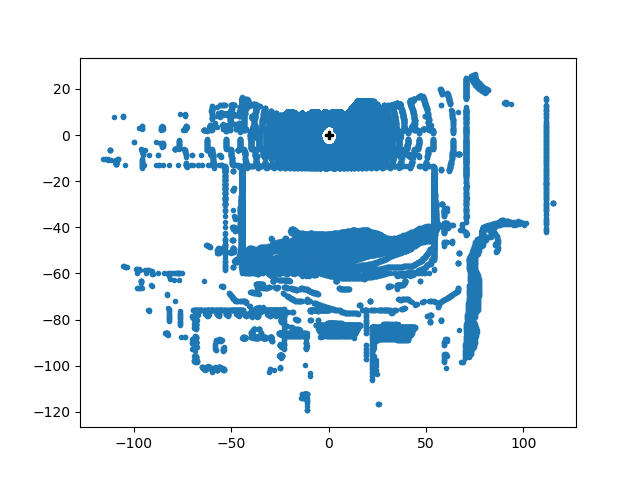

<IPython.core.display.Javascript object>


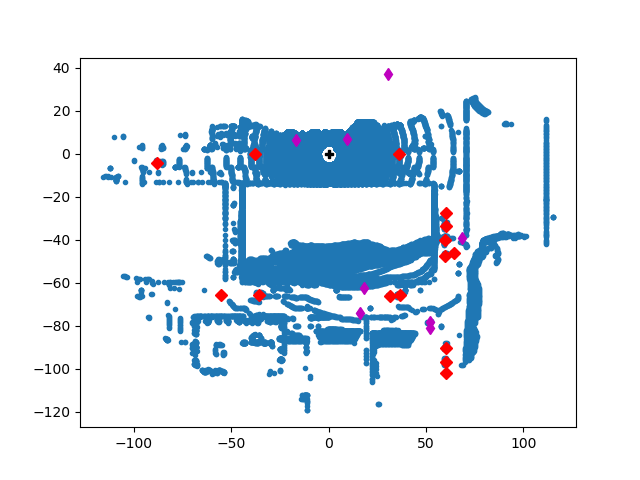

Black +: Lidar center | Red diamond: Vehicle | Magenta diamond: Pedestrian


,id,type,location_x,location_y,location_z,yaw,extent_x,extent_y,extent_z,min_half_extent,max_half_extent
3,1385885768,vehicle,238.914856,133.626938,38.116814,-0.015381,1.934053,0.953285,0.940000,0.476643,0.967027
4,3604685993,vehicle,310.571075,198.957886,38.098103,-0.004944,1.834424,0.832002,0.761607,0.416001,0.917212
14,1702888184,vehicle,334.609314,171.511520,38.069477,89.874756,0.667911,0.383117,0.371510,0.191558,0.333956
15,3767428165,vehicle,334.812958,97.104210,38.134659,90.085075,0.667911,0.383117,0.371510,0.191558,0.333956
20,2344878684,vehicle,334.604492,165.771591,38.099976,89.981895,1.859311,0.837539,0.767747,0.418769,0.929655
22,4056540503,vehicle,334.491638,151.743225,38.062134,89.804420,2.684597,0.916354,0.707550,0.458177,1.342298
24,590584540,vehicle,236.763412,199.183746,38.116814,-0.018433,1.934053,0.953285,0.940000,0.476643,0.967027
27,3734843222,vehicle,334.454254,158.906616,38.097874,89.900650,2.259523,0.865187,1.013224,0.432594,1.129761
41,3125106836,vehicle,311.237823,133.366165,38.099979,0.257038,1.859311,0.837539,0.767747,0.418769,0.929655
47,3259898362,vehicle,334.599060,108.799072,38.096306,89.961502,2.413923,1.030329,0.544018,0.515165,1.206961


In [12]:
# For example
sample_row = df_gt.iloc[np.random.choice(df_gt.shape[0])]
# sample_row = gt_row
sample_step_idx = int(sample_row['step'])
sample_json_file = str(sample_step_idx) + ".json"
sample_ply = str(sample_step_idx) + ".ply"

json_file_path = os.path.join(NONPLAYERS_PATH, sample_json_file)

with open(json_file_path, "r") as json_file_data:
    json_file_str = json_file_data.read()
    
dynamic_non_player_type_list = ["vehicle", "pedestrian"]

non_player_str_list = re.split("non_player_agents", json_file_str)
non_player_str_list

dynamic_str_list = [non_player_str for non_player_str in non_player_str_list[1:]\
                                    for non_player_type in dynamic_non_player_type_list\
                                      if non_player_type in non_player_str]

dataframe_list = []
for dynamic_str in dynamic_str_list:
    clean_str_list = [some_str for some_str in re.split("[:{}\n ]", dynamic_str) if some_str]
    try:
        dataframe_list.append(parse_clean_list(clean_str_list))
    except:
        pass

df_nonplayer = pd.DataFrame(dataframe_list)

lidar_center = np.array([sample_row['location_x'], sample_row['location_y']])
df_feasible_nonplayer = df_nonplayer[np.array([np.linalg.norm(lidar_center - np.array([row['location_x'], row['location_y']])) < (LIDAR_RANGE + row['min_half_extent']) \
                                         for idx, row in df_nonplayer.iterrows()])]



this_pcd = o3d.io.read_point_cloud(os.path.join(DYNAMIC_PATH, sub_folder, PCD_FOLDER, sample_ply))
that_pcd = copy.deepcopy(this_pcd)

that_pcd_arr = np.asarray(that_pcd.points)
that_pcd_arr = np.array([np.array([-y,x,-z]) for x,y,z in that_pcd_arr])
that_pcd.points = o3d.utility.Vector3dVector(that_pcd_arr)

# transform_mat = pose2matrix([0, 0, 0], [sample_row['rotation_roll'],sample_row['rotation_pitch'],sample_row['rotation_yaw']])
transform_mat = pose2matrix([0,0,0], [0,0,sample_row['rotation_yaw']])
that_pcd.transform(transform_mat)
that_pcd_arr = np.asarray(that_pcd.points)
# that_pcd_arr = this_pcd_align_arr
# that_pcd_arr = np.array([np.array([x,y,z]) for x,y,z in that_pcd_arr if z < 2])



plt.figure()
plt.plot(sample_row['location_x']-sample_row['location_x'], sample_row['location_y']-sample_row['location_y'], 'P', c='k')
plt.plot(that_pcd_arr[:,0],that_pcd_arr[:,1], '.')

plt.figure()
plt.plot(sample_row['location_x']-sample_row['location_x'], sample_row['location_y']-sample_row['location_y'], 'P', c='k')
plt.plot(that_pcd_arr[:,0],that_pcd_arr[:,1], '.')
plt.plot(df_feasible_nonplayer[df_feasible_nonplayer['type']=='vehicle']['location_x']-sample_row['location_x'], df_feasible_nonplayer[df_feasible_nonplayer['type']=='vehicle']['location_y']-sample_row['location_y'], 'D', c='r')
plt.plot(df_feasible_nonplayer[df_feasible_nonplayer['type']=='pedestrian']['location_x']-sample_row['location_x'], df_feasible_nonplayer[df_feasible_nonplayer['type']=='pedestrian']['location_y']-sample_row['location_y'], 'd', c='m')

print("Black +: Lidar center | Red diamond: Vehicle | Magenta diamond: Pedestrian")
df_feasible_nonplayer